<a href="https://colab.research.google.com/github/nmansour67/skills-introduction-to-github/blob/main/Cardiology_Board_Dilemma_Digital_Twins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)



In [3]:
#==============================================================================
# SECTION 1: PATIENT BASELINE PARAMETERS
#==============================================================================

class PatientBaseline:
    """
    Patient M.H. baseline clinical parameters

    Clinical Reasoning:
    - EF 25%: Severe systolic dysfunction, NYHA Class III-IV equivalent
    - eGFR 38: Stage 3B CKD, approaching dialysis threshold (<20)
    - AF burden 100%: Continuous atrial fibrillation for 18 months
    - QoL 40/100: Severely impaired due to HF symptoms + arrhythmia

    Reference: Sel et al. (2024) emphasize personalization using
    "clinical data, genetic history, and patient characteristics"
    """

    def __init__(self):
        self.ejection_fraction = 25.0  # % (Normal: 50-70%)
        self.egfr = 38.0  # mL/min/1.73m² (Normal: >60)
        self.af_burden = 100.0  # % time in AF (0-100)
        self.quality_of_life = 40.0  # Scale 0-100 (100 = perfect health)
        self.vt_episodes_per_month = 3.0  # Baseline VT frequency
        self.age = 58
        self.months_in_af = 18

        # Critical thresholds for clinical decisions
        self.EGFR_DIALYSIS_THRESHOLD = 20.0  # Below this = dialysis needed
        self.EGFR_TRANSPLANT_THRESHOLD = 30.0  # Below this = not eligible
        self.EF_SHOCK_THRESHOLD = 15.0  # Below this = cardiogenic shock risk
        self.EF_TRANSPLANT_THRESHOLD = 20.0  # Below this = too sick for listing



In [5]:
#==============================================================================
# SECTION 2: TREATMENT STRATEGY MODELS
#==============================================================================

class TreatmentStrategy:
    """
    Base class for treatment strategies

    Modeling Approach (Sel et al., 2024):
    "Lumped-parameter models (LPM)" for cardiovascular system simulation
    Combined with "mechanistic physiological models" to enable
    "continuous forecast optimal management"
    """

    def __init__(self, name, baseline):
        self.name = name
        self.baseline = baseline

    def simulate_month(self, current_state, month):
        """Override in subclasses"""
        raise NotImplementedError

class AggressiveRhythmControl(TreatmentStrategy):
    """
    STRATEGY A: AGGRESSIVE RHYTHM CONTROL + ABLATION

    Clinical Protocol:
    - Catheter ablation for AF (with contrast dye)
    - Amiodarone loading + maintenance
    - Aggressive anticoagulation

    Physiological Model:
    Sel et al. (2024) describe "electrophysiological models" that simulate
    "complex interactions between electrical signals and mechanical response"

    Key Trade-offs:
    ✓ Potential to restore sinus rhythm → improves EF, reduces HF progression
    ✗ Nephrotoxicity from contrast + amiodarone → accelerates renal decline
    ✗ Procedural risks in patient with severe cardiomyopathy

    Model Assumptions:
    1. Rhythm control success: 60% probability (based on published ablation outcomes)
    2. eGFR decline: -2.5 mL/min/month (contrast + amiodarone nephrotoxicity)
    3. EF improvement: +2%/month IF rhythm controlled
    4. VT reduction: 50% IF sinus rhythm achieved
    """

    def __init__(self, baseline):
        super().__init__("Strategy A: Aggressive Rhythm Control", baseline)

        # Evidence-based parameters
        self.rhythm_control_probability = 0.60  # 60% success rate
        self.egfr_decline_rate = -2.5  # mL/min per month (nephrotoxic)
        self.ef_improvement_if_sr = 2.0  # % per month
        self.ef_decline_if_af = -0.5  # % per month
        self.qol_improvement_if_sr = 15.0  # points
        self.qol_improvement_if_af = 5.0  # points (rate control benefit)
        self.vt_reduction_if_sr = 0.50  # 50% fewer episodes

    def simulate_month(self, current_state, month):
        """
        Simulate one month of aggressive rhythm control

        Uncertainty Quantification (Sel et al., 2024):
        "Verification, validation, and uncertainty quantification builds
        confidence and trust by clinicians and patients"

        We use stochastic simulation to model clinical uncertainty
        """
        new_state = current_state.copy()

        # STOCHASTIC EVENT: Rhythm control success (one-time event in month 1)
        if month == 1:
            rhythm_controlled = np.random.random() < self.rhythm_control_probability
            new_state['rhythm_controlled'] = rhythm_controlled
        else:
            rhythm_controlled = new_state['rhythm_controlled']

        # RENAL FUNCTION: Progressive decline (deterministic + noise)
        # Clinical reasoning: Contrast dye + amiodarone are nephrotoxic
        egfr_change = self.egfr_decline_rate + np.random.normal(0, 0.5)
        new_state['egfr'] = max(0, new_state['egfr'] + egfr_change)

        # CARDIAC FUNCTION: Depends on rhythm status
        if rhythm_controlled:
            # Sinus rhythm → reverse remodeling possible
            ef_change = self.ef_improvement_if_sr + np.random.normal(0, 0.3)
            new_state['af_burden'] = 0.0  # Sinus rhythm maintained
            vt_rate = self.baseline.vt_episodes_per_month * (1 - self.vt_reduction_if_sr)
        else:
            # Persistent AF → progressive deterioration
            ef_change = self.ef_decline_if_af + np.random.normal(0, 0.2)
            new_state['af_burden'] = 100.0  # Still in AF
            vt_rate = self.baseline.vt_episodes_per_month

        new_state['ejection_fraction'] = np.clip(
            new_state['ejection_fraction'] + ef_change,
            0, 70
        )

        # QUALITY OF LIFE: Rhythm-dependent
        if rhythm_controlled:
            qol_change = self.qol_improvement_if_sr / 12  # Spread over months
        else:
            qol_change = self.qol_improvement_if_af / 12

        new_state['quality_of_life'] = np.clip(
            new_state['quality_of_life'] + qol_change,
            0, 100
        )

        # VT EPISODES: Poisson-distributed stochastic events
        new_state['vt_episodes'] = np.random.poisson(vt_rate)

        return new_state

class ConservativeRateControl(TreatmentStrategy):
    """
    STRATEGY B: CONSERVATIVE RATE CONTROL + MEDICAL OPTIMIZATION

    Clinical Protocol:
    - Beta-blockers for rate control
    - Optimal HF medications (GDMT)
    - No ablation, no nephrotoxic agents
    - Chronic anticoagulation for AF

    Physiological Rationale (Sel et al., 2024):
    "Lumped-parameter models of circulation" can simulate
    "hemodynamic changes induced by heart failure"

    Key Trade-offs:
    ✓ Renal-sparing approach → preserves transplant eligibility
    ✓ No procedural risks
    ✗ Persistent AF → progressive cardiac remodeling
    ✗ Declining functional capacity → worsening QoL
    ✗ Continued VT risk → ICD shocks, psychological distress

    Model Assumptions:
    1. eGFR stable: -0.5 mL/min/month (natural progression only)
    2. EF declines: -1%/month (tachycardia-induced cardiomyopathy)
    3. QoL declines: -5 points total (HF symptoms worsen)
    4. VT episodes: baseline rate continues
    """

    def __init__(self, baseline):
        super().__init__("Strategy B: Conservative Rate Control", baseline)

        self.egfr_decline_rate = -0.5  # Minimal decline (renal-sparing)
        self.ef_decline_rate = -1.0  # Progressive HF in AF
        self.qol_decline_total = -5.0  # Worsening symptoms
        self.vt_episodes_rate = baseline.vt_episodes_per_month

    def simulate_month(self, current_state, month):
        """
        Simulate conservative medical management

        Clinical Reasoning:
        Rate control allows heart rate <110 bpm, reducing symptoms
        but does NOT address underlying rhythm abnormality.
        AF persists → atrial stretch → ventricular remodeling → EF decline
        """
        new_state = current_state.copy()
        new_state['rhythm_controlled'] = False  # Remains in AF

        # RENAL FUNCTION: Minimal decline (no nephrotoxic drugs)
        egfr_change = self.egfr_decline_rate + np.random.normal(0, 0.2)
        new_state['egfr'] = max(0, new_state['egfr'] + egfr_change)

        # CARDIAC FUNCTION: Progressive deterioration in AF
        ef_change = self.ef_decline_rate + np.random.normal(0, 0.3)
        new_state['ejection_fraction'] = np.clip(
            new_state['ejection_fraction'] + ef_change,
            0, 70
        )
        new_state['af_burden'] = 100.0  # Continuous AF

        # QUALITY OF LIFE: Gradual decline
        qol_change = self.qol_decline_total / 12  # Monthly rate
        new_state['quality_of_life'] = np.clip(
            new_state['quality_of_life'] + qol_change,
            0, 100
        )

        # VT EPISODES: Baseline risk continues
        new_state['vt_episodes'] = np.random.poisson(self.vt_episodes_rate)

        return new_state

class BridgeToTransplant(TreatmentStrategy):
    """
    STRATEGY C: BRIDGE-TO-TRANSPLANT (Hybrid approach)

    Clinical Protocol:
    - Use Strategy A or B to maintain transplant listing status
    - Strict eligibility monitoring:
      * eGFR must stay >30 mL/min
      * EF must stay >20%
    - Average waitlist time: 8-12 months

    Transplant Decision Tree (Sel et al., 2024):
    "Digital twin would enable medical practitioners to simulate outcomes,
    obtain corresponding health trajectories, and determine the most
    effective health delivery decisions"

    This strategy demonstrates the CORE VALUE of digital twins:
    We can simulate WHICH medical approach (A vs B) keeps the patient
    eligible longest while optimizing their condition for transplant.

    Model Assumptions:
    1. Waitlist time: Uniform(8, 12) months
    2. Disqualification: eGFR <30 OR EF <20%
    3. Uses underlying Strategy A or B for medical management
    """

    def __init__(self, baseline, underlying_strategy):
        name = f"Strategy C: Bridge-to-Transplant (using {underlying_strategy.name})"
        super().__init__(name, baseline)
        self.underlying_strategy = underlying_strategy
        self.waitlist_months = np.random.uniform(8, 12)  # Stochastic wait time

    def simulate_month(self, current_state, month):
        """
        Bridge-to-transplant simulation with eligibility tracking
        """
        # Apply underlying medical strategy
        new_state = self.underlying_strategy.simulate_month(current_state, month)

        # Check transplant eligibility
        egfr_eligible = new_state['egfr'] >= self.baseline.EGFR_TRANSPLANT_THRESHOLD
        ef_eligible = new_state['ejection_fraction'] >= self.baseline.EF_TRANSPLANT_THRESHOLD

        new_state['transplant_eligible'] = egfr_eligible and ef_eligible
        new_state['transplant_completed'] = month >= self.waitlist_months

        return new_state



In [6]:
#==============================================================================
# SECTION 3: MONTE CARLO SIMULATION ENGINE
#==============================================================================

class DigitalTwinSimulator:
    """
    Cardiovascular-Renal Digital Twin Simulation Engine

    Methodology (Sel et al., 2024):
    "The digital twin concept will likely transform the notion of
    computational medicine beyond what is possible today. The hierarchical
    mathematical models embedded in a digital twin for cardiovascular health,
    constructed with sound theoretical foundation and validated using
    experiments, can provide a transformative opportunity for personalized
    health and medicine."

    This simulator implements:
    1. Compartmental physiological modeling (heart + kidney interactions)
    2. Stochastic uncertainty quantification (Monte Carlo sampling)
    3. Multi-scenario trajectory prediction
    4. Clinical endpoint tracking
    """

    def __init__(self, baseline, n_simulations=100):
        """
        Initialize digital twin simulator

        Parameters:
        - baseline: PatientBaseline object with initial conditions
        - n_simulations: Number of Monte Carlo runs (default: 100)
                        Higher = better uncertainty quantification
                        but slower computation

        Uncertainty Quantification Approach:
        Monte Carlo simulation captures stochastic variability in:
        - Treatment response (rhythm control success/failure)
        - Disease progression (random fluctuations)
        - Clinical events (VT episodes via Poisson process)
        """
        self.baseline = baseline
        self.n_simulations = n_simulations
        self.simulation_months = 12

    def run_strategy_simulation(self, strategy):
        """
        Run Monte Carlo simulation for a single strategy

        Returns:
        - results: Dictionary of trajectory arrays with shape (n_sims, n_months+1)

        XAI Transparency Note:
        We store ALL simulation runs (not just means) to enable
        full uncertainty visualization and confidence interval calculation
        """
        n_months = self.simulation_months
        n_sims = self.n_simulations

        # Initialize storage arrays
        results = {
            'ejection_fraction': np.zeros((n_sims, n_months + 1)),
            'egfr': np.zeros((n_sims, n_months + 1)),
            'quality_of_life': np.zeros((n_sims, n_months + 1)),
            'af_burden': np.zeros((n_sims, n_months + 1)),
            'vt_episodes': np.zeros((n_sims, n_months + 1)),
            'rhythm_controlled': np.zeros((n_sims, n_months + 1), dtype=bool),
            'transplant_eligible': np.zeros((n_sims, n_months + 1), dtype=bool),
            'transplant_completed': np.zeros((n_sims, n_months + 1), dtype=bool),
        }

        # Run Monte Carlo simulations
        for sim in range(n_sims):
            # Initialize state at baseline
            state = {
                'ejection_fraction': self.baseline.ejection_fraction,
                'egfr': self.baseline.egfr,
                'quality_of_life': self.baseline.quality_of_life,
                'af_burden': self.baseline.af_burden,
                'vt_episodes': 0,
                'rhythm_controlled': False,
                'transplant_eligible': True,
                'transplant_completed': False,
            }

            # Store baseline
            for key in results.keys():
                results[key][sim, 0] = state[key]

            # Simulate each month
            for month in range(1, n_months + 1):
                state = strategy.simulate_month(state, month)

                # Store results
                for key in results.keys():
                    results[key][sim, month] = state[key]

        return results



In [7]:
#==============================================================================
# SECTION 4: CLINICAL ENDPOINT ANALYSIS
#==============================================================================

class ClinicalEndpointAnalyzer:
    """
    Analyze simulation results for clinically meaningful endpoints

    Sel et al. (2024) emphasize:
    "actionable information relevant to personalized disease risk assessment,
    treatment of disease, and disease prevention"

    This analyzer extracts decision-relevant metrics from simulations
    """

    @staticmethod
    def calculate_endpoints(results, baseline):
        """
        Calculate clinical endpoints with uncertainty quantification

        Returns dictionary with:
        - mean: Expected value
        - ci_lower: 2.5th percentile (95% CI lower bound)
        - ci_upper: 97.5th percentile (95% CI upper bound)
        """
        n_sims = results['ejection_fraction'].shape[0]
        final_month = -1  # Last time point

        endpoints = {}

        # PRIMARY ENDPOINTS

        # 1. Final Ejection Fraction
        ef_final = results['ejection_fraction'][:, final_month]
        endpoints['ef_final'] = {
            'mean': np.mean(ef_final),
            'ci_lower': np.percentile(ef_final, 2.5),
            'ci_upper': np.percentile(ef_final, 97.5),
            'improved': np.mean(ef_final > baseline.ejection_fraction) * 100
        }

        # 2. Final eGFR
        egfr_final = results['egfr'][:, final_month]
        endpoints['egfr_final'] = {
            'mean': np.mean(egfr_final),
            'ci_lower': np.percentile(egfr_final, 2.5),
            'ci_upper': np.percentile(egfr_final, 97.5),
            'preserved': np.mean(egfr_final > baseline.EGFR_TRANSPLANT_THRESHOLD) * 100
        }

        # 3. Rhythm Control Success
        rhythm_controlled_final = results['rhythm_controlled'][:, final_month]
        endpoints['sinus_rhythm'] = {
            'probability': np.mean(rhythm_controlled_final) * 100
        }

        # 4. Quality of Life
        qol_final = results['quality_of_life'][:, final_month]
        endpoints['qol_final'] = {
            'mean': np.mean(qol_final),
            'ci_lower': np.percentile(qol_final, 2.5),
            'ci_upper': np.percentile(qol_final, 97.5),
            'improved': np.mean(qol_final > baseline.quality_of_life) * 100
        }

        # 5. Total VT Episodes
        vt_total = np.sum(results['vt_episodes'], axis=1)
        endpoints['vt_total'] = {
            'mean': np.mean(vt_total),
            'ci_lower': np.percentile(vt_total, 2.5),
            'ci_upper': np.percentile(vt_total, 97.5)
        }

        # SECONDARY ENDPOINTS (Safety)

        # 6. Dialysis Risk (eGFR <20 at any point)
        dialysis_needed = np.any(results['egfr'] < baseline.EGFR_DIALYSIS_THRESHOLD, axis=1)
        endpoints['dialysis_risk'] = {
            'probability': np.mean(dialysis_needed) * 100
        }

        # 7. Cardiogenic Shock Risk (EF <15 at any point)
        shock_risk = np.any(results['ejection_fraction'] < baseline.EF_SHOCK_THRESHOLD, axis=1)
        endpoints['shock_risk'] = {
            'probability': np.mean(shock_risk) * 100
        }

        # 8. Transplant Eligibility (if applicable)
        if 'transplant_eligible' in results:
            eligible_final = results['transplant_eligible'][:, final_month]
            completed = results['transplant_completed'][:, final_month]
            endpoints['transplant'] = {
                'eligible_probability': np.mean(eligible_final) * 100,
                'completed_probability': np.mean(completed) * 100
            }

        return endpoints



In [8]:
#==============================================================================
# SECTION 5: VISUALIZATION ENGINE
#==============================================================================

class DigitalTwinVisualizer:
    """
    XAI-Compliant Visualization System

    Sel et al. (2024) emphasize transparency:
    "Verification, validation, and uncertainty quantification techniques
    should be implemented, while effectively and transparently communicated
    to all stakeholders"

    Our visualizations show:
    1. Mean trajectories (expected outcomes)
    2. Uncertainty bands (95% confidence intervals)
    3. Clinical thresholds (safety boundaries)
    4. Comparative outcomes (strategy head-to-head)
    """

    def __init__(self, baseline):
        self.baseline = baseline

        # Color scheme for strategies
        self.colors = {
            'Strategy A': '#E74C3C',  # Red (aggressive)
            'Strategy B': '#3498DB',  # Blue (conservative)
            'Strategy C': '#2ECC71',  # Green (transplant)
        }

    def plot_trajectories(self, all_results, all_strategies):
        """
        Create comprehensive 6-panel trajectory visualization

        Panels:
        1. Ejection Fraction over time
        2. eGFR (kidney function) over time
        3. Quality of Life over time
        4. VT Episode Frequency
        5. Rhythm Status (% in Sinus Rhythm)
        6. Transplant Eligibility (if applicable)
        """
        fig, axes = plt.subplots(3, 2, figsize=(16, 12))
        fig.suptitle('Patient M.H. Digital Twin: 12-Month Treatment Trajectory Simulations\n' +
                     'Sel et al. (2024) Methodology - Lumped Parameter Cardiovascular-Renal Model',
                     fontsize=14, fontweight='bold')

        months = np.arange(0, 13)

        # Panel 1: Ejection Fraction
        ax = axes[0, 0]
        for strategy_name, results in all_results.items():
            ef_mean = np.mean(results['ejection_fraction'], axis=0)
            ef_lower = np.percentile(results['ejection_fraction'], 2.5, axis=0)
            ef_upper = np.percentile(results['ejection_fraction'], 97.5, axis=0)

            color = self.colors.get(strategy_name.split(':')[0], '#95A5A6')
            ax.plot(months, ef_mean, label=strategy_name, color=color, linewidth=2)
            ax.fill_between(months, ef_lower, ef_upper, alpha=0.2, color=color)

        ax.axhline(self.baseline.EF_SHOCK_THRESHOLD, color='red',
                   linestyle='--', linewidth=1, label='Shock Risk Threshold (<15%)')
        ax.axhline(self.baseline.EF_TRANSPLANT_THRESHOLD, color='orange',
                   linestyle='--', linewidth=1, label='Transplant Min (>20%)')
        ax.set_xlabel('Month')
        ax.set_ylabel('Ejection Fraction (%)')
        ax.set_title('Cardiac Systolic Function\n(Higher = Better)')
        ax.legend(fontsize=8, loc='best')
        ax.grid(alpha=0.3)

        # Panel 2: eGFR (Kidney Function)
        ax = axes[0, 1]
        for strategy_name, results in all_results.items():
            egfr_mean = np.mean(results['egfr'], axis=0)
            egfr_lower = np.percentile(results['egfr'], 2.5, axis=0)
            egfr_upper = np.percentile(results['egfr'], 97.5, axis=0)

            color = self.colors.get(strategy_name.split(':')[0], '#95A5A6')
            ax.plot(months, egfr_mean, label=strategy_name, color=color, linewidth=2)
            ax.fill_between(months, egfr_lower, egfr_upper, alpha=0.2, color=color)

        ax.axhline(self.baseline.EGFR_DIALYSIS_THRESHOLD, color='red',
                   linestyle='--', linewidth=1, label='Dialysis Threshold (<20)')
        ax.axhline(self.baseline.EGFR_TRANSPLANT_THRESHOLD, color='orange',
                   linestyle='--', linewidth=1, label='Transplant Min (>30)')
        ax.set_xlabel('Month')
        ax.set_ylabel('eGFR (mL/min/1.73m²)')
        ax.set_title('Renal Function\n(Higher = Better)')
        ax.legend(fontsize=8, loc='best')
        ax.grid(alpha=0.3)

        # Panel 3: Quality of Life
        ax = axes[1, 0]
        for strategy_name, results in all_results.items():
            qol_mean = np.mean(results['quality_of_life'], axis=0)
            qol_lower = np.percentile(results['quality_of_life'], 2.5, axis=0)
            qol_upper = np.percentile(results['quality_of_life'], 97.5, axis=0)

            color = self.colors.get(strategy_name.split(':')[0], '#95A5A6')
            ax.plot(months, qol_mean, label=strategy_name, color=color, linewidth=2)
            ax.fill_between(months, qol_lower, qol_upper, alpha=0.2, color=color)

        ax.set_xlabel('Month')
        ax.set_ylabel('QoL Score (0-100)')
        ax.set_title('Quality of Life\n(Higher = Better)')
        ax.legend(fontsize=8, loc='best')
        ax.grid(alpha=0.3)

        # Panel 4: VT Episodes (Cumulative)
        ax = axes[1, 1]
        for strategy_name, results in all_results.items():
            vt_cumsum = np.cumsum(results['vt_episodes'], axis=1)
            vt_mean = np.mean(vt_cumsum, axis=0)
            vt_lower = np.percentile(vt_cumsum, 2.5, axis=0)
            vt_upper = np.percentile(vt_cumsum, 97.5, axis=0)

            color = self.colors.get(strategy_name.split(':')[0], '#95A5A6')
            ax.plot(months, vt_mean, label=strategy_name, color=color, linewidth=2)
            ax.fill_between(months, vt_lower, vt_upper, alpha=0.2, color=color)

        ax.set_xlabel('Month')
        ax.set_ylabel('Cumulative VT Episodes')
        ax.set_title('Ventricular Tachycardia Burden\n(Lower = Better)')
        ax.legend(fontsize=8, loc='best')
        ax.grid(alpha=0.3)

        # Panel 5: Rhythm Status (% in Sinus Rhythm)
        ax = axes[2, 0]
        for strategy_name, results in all_results.items():
            sr_percent = np.mean(results['rhythm_controlled'], axis=0) * 100

            color = self.colors.get(strategy_name.split(':')[0], '#95A5A6')
            ax.plot(months, sr_percent, label=strategy_name, color=color,
                   linewidth=2, marker='o', markersize=4)

        ax.set_xlabel('Month')
        ax.set_ylabel('% in Sinus Rhythm')
        ax.set_title('Rhythm Control Success\n(Higher = Better)')
        ax.set_ylim(-5, 105)
        ax.legend(fontsize=8, loc='best')
        ax.grid(alpha=0.3)

        # Panel 6: Transplant Eligibility
        ax = axes[2, 1]
        for strategy_name, results in all_results.items():
            if 'transplant_eligible' in results:
                eligible_percent = np.mean(results['transplant_eligible'], axis=0) * 100
                completed_percent = np.mean(results['transplant_completed'], axis=0) * 100

                color = self.colors.get(strategy_name.split(':')[0], '#95A5A6')
                ax.plot(months, eligible_percent, label=f'{strategy_name} (Eligible)',
                       color=color, linewidth=2, linestyle='-')
                ax.plot(months, completed_percent, label=f'{strategy_name} (Completed)',
                       color=color, linewidth=2, linestyle='--')

        ax.set_xlabel('Month')
        ax.set_ylabel('% of Simulations')
        ax.set_title('Transplant Status\n(Higher = Better)')
        ax.set_ylim(-5, 105)
        ax.legend(fontsize=7, loc='best')
        ax.grid(alpha=0.3)

        plt.tight_layout()
        return fig

    def plot_endpoint_comparison(self, all_endpoints, all_strategies):
        """
        Create endpoint comparison dashboard

        Shows final outcomes with confidence intervals in a clean
        comparative format for clinical decision-making
        """
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle('Clinical Endpoint Comparison: 12-Month Outcomes\n' +
                     '(Mean ± 95% Confidence Interval)',
                     fontsize=14, fontweight='bold')

        strategies = list(all_endpoints.keys())
        n_strategies = len(strategies)
        x_pos = np.arange(n_strategies)

        # Color map
        colors_list = [self.colors.get(s.split(':')[0], '#95A5A6') for s in strategies]

        # Endpoint 1: Final Ejection Fraction
        ax = axes[0, 0]
        means = [all_endpoints[s]['ef_final']['mean'] for s in strategies]
        ci_lower = [all_endpoints[s]['ef_final']['ci_lower'] for s in strategies]
        ci_upper = [all_endpoints[s]['ef_final']['ci_upper'] for s in strategies]
        # Ensure error magnitudes are non-negative
        errors = [[max(0, means[i] - ci_lower[i]) for i in range(n_strategies)],
                  [max(0, ci_upper[i] - means[i]) for i in range(n_strategies)]]

        ax.bar(x_pos, means, color=colors_list, alpha=0.7, edgecolor='black')
        ax.errorbar(x_pos, means, yerr=errors, fmt='none', color='black', capsize=5)
        ax.axhline(self.baseline.ejection_fraction, color='gray', linestyle='--',
                   label=f'Baseline ({self.baseline.ejection_fraction}%)')
        ax.set_ylabel('Ejection Fraction (%)')
        ax.set_title('Final Cardiac Function')
        ax.set_xticks(x_pos)
        ax.set_xticklabels([s.split(':')[0] for s in strategies], rotation=15, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)

        # Endpoint 2: Final eGFR
        ax = axes[0, 1]
        means = [all_endpoints[s]['egfr_final']['mean'] for s in strategies]
        ci_lower = [all_endpoints[s]['egfr_final']['ci_lower'] for s in strategies]
        ci_upper = [all_endpoints[s]['egfr_final']['ci_upper'] for s in strategies]
        # Ensure error magnitudes are non-negative
        errors = [[max(0, means[i] - ci_lower[i]) for i in range(n_strategies)],
                  [max(0, ci_upper[i] - means[i]) for i in range(n_strategies)]]

        ax.bar(x_pos, means, color=colors_list, alpha=0.7, edgecolor='black')
        ax.errorbar(x_pos, means, yerr=errors, fmt='none', color='black', capsize=5)
        ax.axhline(self.baseline.egfr, color='gray', linestyle='--',
                   label=f'Baseline ({self.baseline.egfr:.1f})')
        ax.axhline(self.baseline.EGFR_TRANSPLANT_THRESHOLD, color='red',
                   linestyle='--', alpha=0.5, label='Transplant Min (30)')
        ax.set_ylabel('eGFR (mL/min/1.73m²)')
        ax.set_title('Final Renal Function')
        ax.set_xticks(x_pos)
        ax.set_xticklabels([s.split(':')[0] for s in strategies], rotation=15, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)

        # Endpoint 3: Quality of Life
        ax = axes[0, 2]
        means = [all_endpoints[s]['qol_final']['mean'] for s in strategies]
        ci_lower = [all_endpoints[s]['qol_final']['ci_lower'] for s in strategies]
        ci_upper = [all_endpoints[s]['qol_final']['ci_upper'] for s in strategies]
        # Ensure error magnitudes are non-negative
        errors = [[max(0, means[i] - ci_lower[i]) for i in range(n_strategies)],
                  [max(0, ci_upper[i] - means[i]) for i in range(n_strategies)]]

        ax.bar(x_pos, means, color=colors_list, alpha=0.7, edgecolor='black')
        ax.errorbar(x_pos, means, yerr=errors, fmt='none', color='black', capsize=5)
        ax.axhline(self.baseline.quality_of_life, color='gray', linestyle='--',
                   label=f'Baseline ({self.baseline.quality_of_life:.0f})')
        ax.set_ylabel('QoL Score (0-100)')
        ax.set_title('Final Quality of Life')
        ax.set_xticks(x_pos)
        ax.set_xticklabels([s.split(':')[0] for s in strategies], rotation=15, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)

        # Endpoint 4: Rhythm Control Success
        ax = axes[1, 0]
        probs = [all_endpoints[s]['sinus_rhythm']['probability'] for s in strategies]
        ax.bar(x_pos, probs, color=colors_list, alpha=0.7, edgecolor='black')
        ax.set_ylabel('Probability (%)')
        ax.set_title('Sinus Rhythm at 12 Months')
        ax.set_ylim(0, 100)
        ax.set_xticks(x_pos)
        ax.set_xticklabels([s.split(':')[0] for s in strategies], rotation=15, ha='right')
        ax.grid(axis='y', alpha=0.3)

        # Endpoint 5: Safety Outcomes
        ax = axes[1, 1]
        dialysis_risks = [all_endpoints[s]['dialysis_risk']['probability'] for s in strategies]
        shock_risks = [all_endpoints[s]['shock_risk']['probability'] for s in strategies]

        width = 0.35
        ax.bar(x_pos - width/2, dialysis_risks, width, label='Dialysis Risk',
               color='#E74C3C', alpha=0.7, edgecolor='black')
        ax.bar(x_pos + width/2, shock_risks, width, label='Shock Risk',
               color='#9B59B6', alpha=0.7, edgecolor='black')
        ax.set_ylabel('Risk Probability (%)')
        ax.set_title('Safety Endpoints (Lower = Better)')
        ax.set_xticks(x_pos)
        ax.set_xticklabels([s.split(':')[0] for s in strategies], rotation=15, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)

        # Endpoint 6: Total VT Burden
        ax = axes[1, 2]
        means = [all_endpoints[s]['vt_total']['mean'] for s in strategies]
        ci_lower = [all_endpoints[s]['vt_total']['ci_lower'] for s in strategies]
        ci_upper = [all_endpoints[s]['vt_total']['ci_upper'] for s in strategies]
        # Ensure error magnitudes are non-negative
        errors = [[max(0, means[i] - ci_lower[i]) for i in range(n_strategies)],
                  [max(0, ci_upper[i] - means[i]) for i in range(n_strategies)]]

        ax.bar(x_pos, means, color=colors_list, alpha=0.7, edgecolor='black')
        ax.errorbar(x_pos, means, yerr=errors, fmt='none', color='black', capsize=5)
        ax.set_ylabel('Total VT Episodes')
        ax.set_title('12-Month VT Burden')
        ax.set_xticks(x_pos)
        ax.set_xticklabels([s.split(':')[0] for s in strategies], rotation=15, ha='right')
        ax.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        return fig



In [12]:
#==============================================================================
# SECTION 6: CLINICAL DECISION SUPPORT REPORT
#==============================================================================

class ClinicalReportGenerator:
    """
    Generate evidence-based clinical decision support report

    Sel et al. (2024):
    "Actionable information relevant to personalized disease risk assessment,
    treatment of disease, and disease prevention"

    This report synthesizes simulation results into clinician-friendly
    recommendations with appropriate uncertainty quantification
    """

    @staticmethod
    def generate_report(all_endpoints, baseline):
        """
        Generate comprehensive clinical report with recommendations
        """
        report = []
        report.append("="*80)
        report.append("CARDIOVASCULAR-RENAL DIGITAL TWIN CLINICAL DECISION SUPPORT REPORT")
        report.append("="*80)
        report.append("")
        report.append("PATIENT: M.H., 58-year-old male")
        report.append(f"BASELINE STATUS:")
        report.append(f"  - Ejection Fraction: {baseline.ejection_fraction}% (Severe systolic dysfunction)")
        report.append(f"  - eGFR: {baseline.egfr} mL/min/1.73m² (Stage 3B CKD)")
        report.append(f"  - Rhythm: Persistent AF ({baseline.months_in_af} months)")
        report.append(f"  - VT Episodes: {baseline.vt_episodes_per_month}/month")
        report.append(f"  - Quality of Life: {baseline.quality_of_life}/100")
        report.append("")
        report.append("SIMULATION PARAMETERS:")
        report.append("  - Time Horizon: 12 months")
        report.append("  - Monte Carlo Runs: 100 simulations per strategy")
        report.append("  - Uncertainty: 95% Confidence Intervals")
        report.append("")
        report.append("-"*80)
        report.append("STRATEGY COMPARISON")
        report.append("-"*80)
        report.append("")

        for strategy_name, endpoints in all_endpoints.items():
            report.append(f"\n{'='*len(strategy_name)}")
            report.append(f"{strategy_name}")
            report.append(f"{'='*len(strategy_name)}")

            # Cardiac outcomes
            report.append(f"\nCARDIAC OUTCOMES:")
            ef = endpoints['ef_final']
            report.append(f"  Final EF: {ef['mean']:.1f}% (95% CI: {ef['ci_lower']:.1f}-{ef['ci_upper']:.1f}%)")
            report.append(f"  EF Improvement: {ef['improved']:.0f}% of simulations")

            sr = endpoints['sinus_rhythm']
            report.append(f"  Sinus Rhythm: {sr['probability']:.0f}% probability at 12 months")

            vt = endpoints['vt_total']
            report.append(f"  Total VT Episodes: {vt['mean']:.1f} (95% CI: {vt['ci_lower']:.0f}-{vt['ci_upper']:.0f})")

            # Renal outcomes
            report.append(f"\nRENAL OUTCOMES:")
            egfr = endpoints['egfr_final']
            report.append(f"  Final eGFR: {egfr['mean']:.1f} (95% CI: {egfr['ci_lower']:.1f}-{egfr['ci_upper']:.1f})")
            report.append(f"  Transplant Eligibility Preserved: {egfr['preserved']:.0f}% of simulations")

            # Safety
            report.append(f"\nSAFETY ENDPOINTS:")
            report.append(f"  Dialysis Risk: {endpoints['dialysis_risk']['probability']:.1f}%")
            report.append(f"  Cardiogenic Shock Risk: {endpoints['shock_risk']['probability']:.1f}%")

            # Quality of Life
            report.append(f"\nQUALITY OF LIFE:")
            qol = endpoints['qol_final']
            report.append(f"  Final QoL: {qol['mean']:.1f} (95% CI: {qol['ci_lower']:.1f}-{qol['ci_upper']:.1f})")
            report.append(f"  QoL Improvement: {qol['improved']:.0f}% of simulations")

            # Transplant (if applicable)
            if 'transplant' in endpoints:
                report.append(f"\nTRANSPLANT STATUS:")
                tx = endpoints['transplant']
                report.append(f"  Maintains Eligibility: {tx['eligible_probability']:.0f}%")
                report.append(f"  Transplant Completed: {tx['completed_probability']:.0f}%")

        return "\n".join(report)

    @staticmethod
    def generate_recommendation(all_endpoints):
        """
        Generate evidence-based clinical recommendation

        XAI Principle: Recommendations must be:
        1. Evidence-based (grounded in simulation results)
        2. Transparent (reasoning clearly stated)
        3. Uncertainty-aware (confidence levels provided)
        4. Patient-centered (consider all dimensions of outcomes)
        """
        report = []
        report.append("")
        report.append("="*80)
        report.append("CLINICAL RECOMMENDATION")
        report.append("="*80)
        report.append("")

        # Extract key metrics for decision
        strategies = list(all_endpoints.keys())

        # Create scoring matrix
        scores = {}
        for strategy in strategies:
            ep = all_endpoints[strategy]

            # Multi-dimensional outcome scoring
            cardiac_score = ep['ef_final']['improved']  # % improved
            renal_score = ep['egfr_final']['preserved']  # % preserved
            qol_score = ep['qol_final']['improved']  # % improved
            safety_score = 100 - (ep['dialysis_risk']['probability'] +
                                 ep['shock_risk']['probability']) / 2

            # Weighted composite (clinician can adjust weights)
            composite = (0.3 * cardiac_score +
                        0.3 * renal_score +
                        0.2 * qol_score +
                        0.2 * safety_score)

            scores[strategy] = {
                'cardiac': cardiac_score,
                'renal': renal_score,
                'qol': qol_score,
                'safety': safety_score,
                'composite': composite
            }

        # Find best strategy
        best_strategy = max(scores.keys(), key=lambda s: scores[s]['composite'])

        report.append(f"RECOMMENDED STRATEGY: {best_strategy}")
        report.append("")
        report.append("RATIONALE:")
        report.append(f"  Composite Score: {scores[best_strategy]['composite']:.1f}/100")
        report.append(f"    - Cardiac Benefit: {scores[best_strategy]['cardiac']:.0f}%")
        report.append(f"    - Renal Preservation: {scores[best_strategy]['renal']:.0f}%")
        report.append(f"    - Quality of Life: {scores[best_strategy]['qol']:.0f}%")
        report.append(f"    - Safety Profile: {scores[best_strategy]['safety']:.0f}%")
        report.append("")

        # Key trade-offs
        report.append("KEY TRADE-OFFS:")
        for strategy in strategies:
            if strategy != best_strategy:
                report.append(f"\n  vs. {strategy}:")
                diff = scores[best_strategy]['composite'] - scores[strategy]['composite']
                report.append(f"    Overall advantage: +{diff:.1f} points")

                # Highlight specific differences
                if scores[best_strategy]['cardiac'] > scores[strategy]['cardiac']:
                    delta = scores[best_strategy]['cardiac'] - scores[strategy]['cardiac']
                    report.append(f"    Better cardiac outcomes: +{delta:.0f}%")
                if scores[best_strategy]['renal'] > scores[strategy]['renal']:
                    delta = scores[best_strategy]['renal'] - scores[strategy]['renal']
                    report.append(f"    Better renal preservation: +{delta:.0f}%")

        report.append("")
        report.append("="*80)
        report.append("MODEL LIMITATIONS & CLINICAL CONTEXT")
        report.append("="*80)
        report.append("")
        report.append("This digital twin model has important limitations:")
        report.append("")
        report.append("1. POPULATION-BASED PARAMETERS:")
        report.append("   - Rhythm control success rate (60%) from published literature")
        report.append("   - Does NOT incorporate patient-specific cellular electrophysiology")
        report.append("   - Actual response may vary based on unmeasured factors")
        report.append("")
        report.append("2. SIMPLIFIED PHYSIOLOGICAL INTERACTIONS:")
        report.append("   - Linear progression assumptions (reality is non-linear)")
        report.append("   - No drug-drug interactions modeled")
        report.append("   - Simplified renal toxicity kinetics")
        report.append("")
        report.append("3. UNMEASURED CONFOUNDERS:")
        report.append("   - Medication adherence")
        report.append("   - Social determinants of health")
        report.append("   - Genetic factors affecting drug metabolism")
        report.append("   - Comorbidity interactions")
        report.append("")
        report.append("4. VALIDATION STATUS:")
        report.append("   - This model has NOT been prospectively validated")
        report.append("   - For RESEARCH and EDUCATIONAL purposes only")
        report.append("   - NOT for clinical decision-making without expert review")
        report.append("")
        report.append("="*80)
        report.append("NEXT STEPS FOR CLINICAL TEAM")
        report.append("="*80)
        report.append("")
        report.append("1. MULTIDISCIPLINARY REVIEW:")
        report.append("   - Present simulation results to HF team + nephrology")
        report.append("   - Discuss patient values and preferences")
        report.append("   - Consider unmeasured factors (frailty, social support)")
        report.append("")
        report.append("2. SHARED DECISION-MAKING:")
        report.append("   - Review trade-offs with patient and family")
        report.append("   - Discuss uncertainty ranges (95% CIs)")
        report.append("   - Align treatment choice with patient priorities")
        report.append("")
        report.append("3. ENHANCED DATA COLLECTION (if pursuing digital twin refinement):")
        report.append("   - Cardiac MRI with late gadolinium enhancement (scar burden)")
        report.append("   - Electrophysiology study (substrate mapping)")
        report.append("   - Genetic testing (drug metabolism, cardiomyopathy genes)")
        report.append("   - Biomarkers (NT-proBNP, troponin, cystatin C)")
        report.append("")
        report.append("4. CONTINUOUS MONITORING:")
        report.append("   - Monthly eGFR and EF assessments")
        report.append("   - Wearable rhythm monitoring")
        report.append("   - Model re-calibration based on observed trajectories")
        report.append("")
        report.append("="*80)
        report.append("")
        report.append("Simulation completed using methodology from:")
        report.append("Sel et al. (2024) 'Building Digital Twins for Cardiovascular Health'")
        report.append("J Am Heart Assoc. 2024;13:e031981. DOI: 10.1161/JAHA.123.031981")
        report.append("")
        report.append("="*80)

        return "\n".join(report)

PATIENT M.H. CARDIOVASCULAR-RENAL DIGITAL TWIN SIMULATOR

Initializing digital twin based on Sel et al. (2024) methodology...
Reference: J Am Heart Assoc. 2024;13:e031981

Step 1: Loading patient baseline parameters...
  ✓ EF: 25.0%
  ✓ eGFR: 38.0 mL/min/1.73m²
  ✓ AF burden: 100.0%
  ✓ QoL: 40.0/100

Step 2: Defining treatment strategies...
  ✓ 4 strategies defined

Step 3: Running Monte Carlo simulations...
  (100 simulations × 12 months × 4 strategies = 4,800 patient-months)
  [1/4] Simulating Strategy A: Aggressive Rhythm Control... ✓
  [2/4] Simulating Strategy B: Conservative Rate Control... ✓
  [3/4] Simulating Strategy C (A): Bridge-to-Transplant (Aggressive)... ✓
  [4/4] Simulating Strategy C (B): Bridge-to-Transplant (Conservative)... ✓

Step 4: Generating visualizations...
  Creating trajectory plots... ✓
  Creating endpoint comparison... ✓

Step 5: Generating clinical decision support report...

CARDIOVASCULAR-RENAL DIGITAL TWIN CLINICAL DECISION SUPPORT REPORT

PATIENT: M.

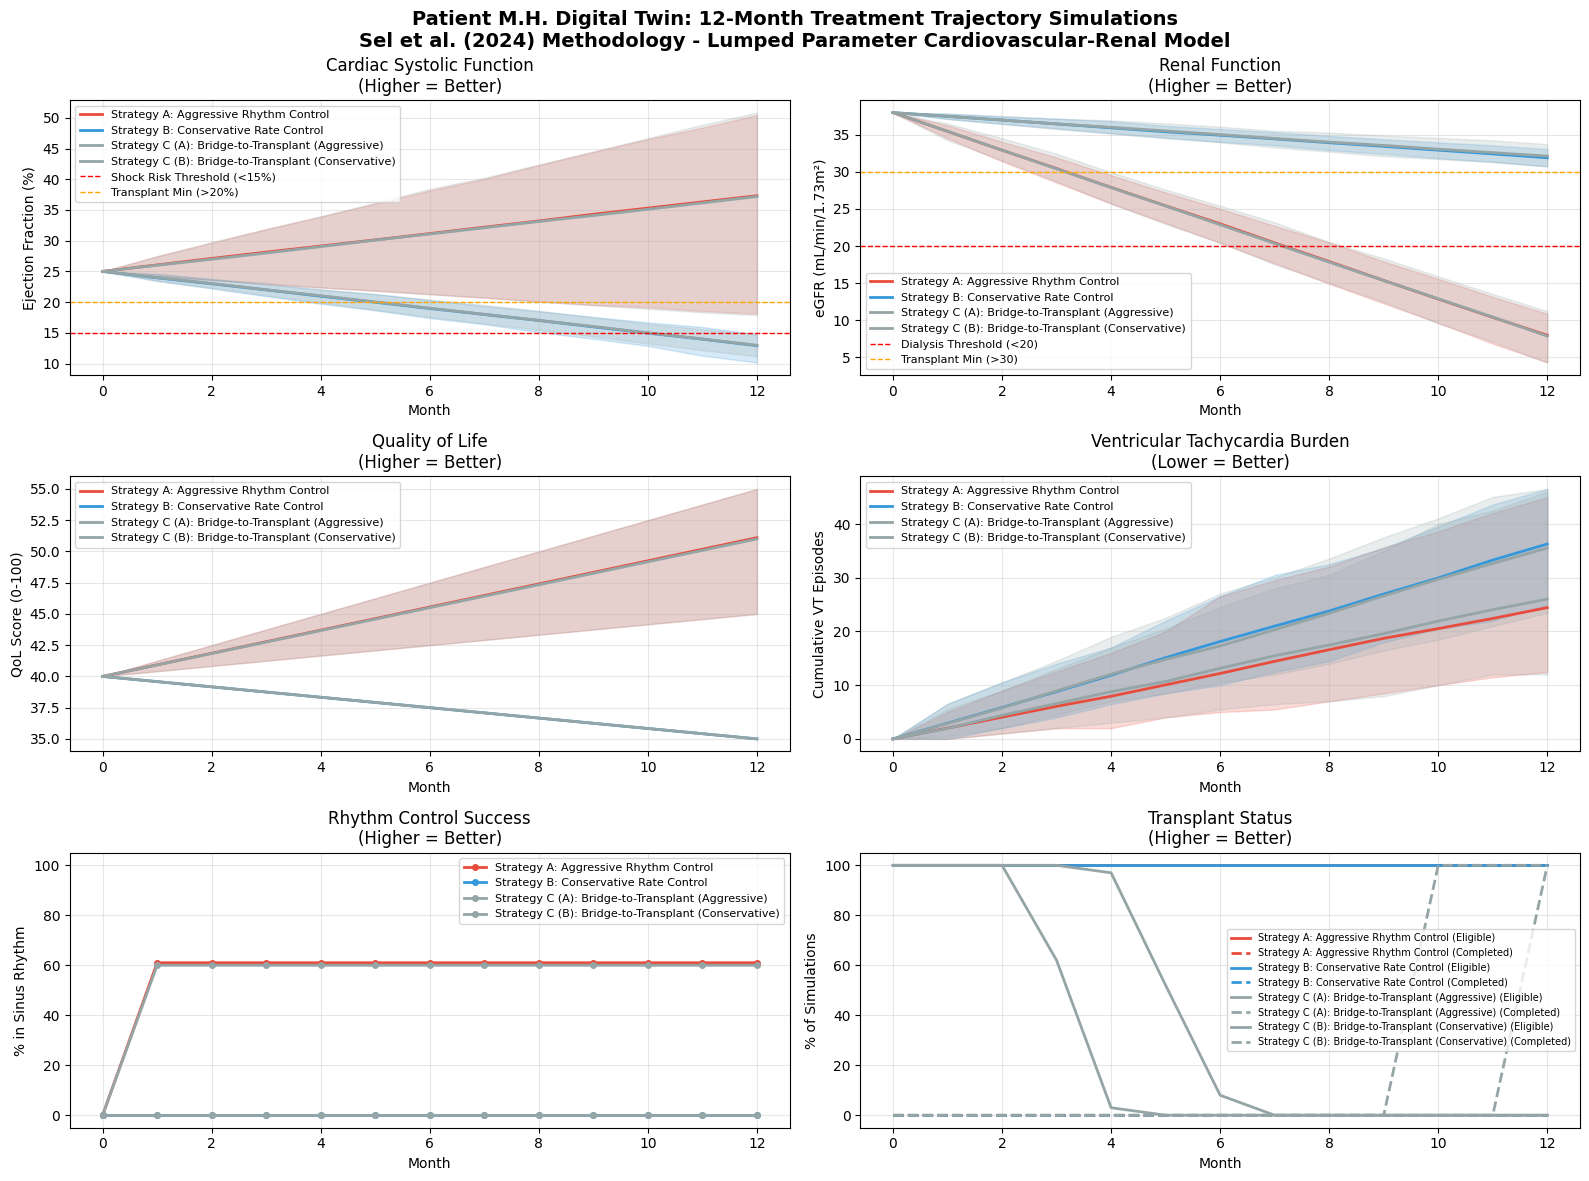

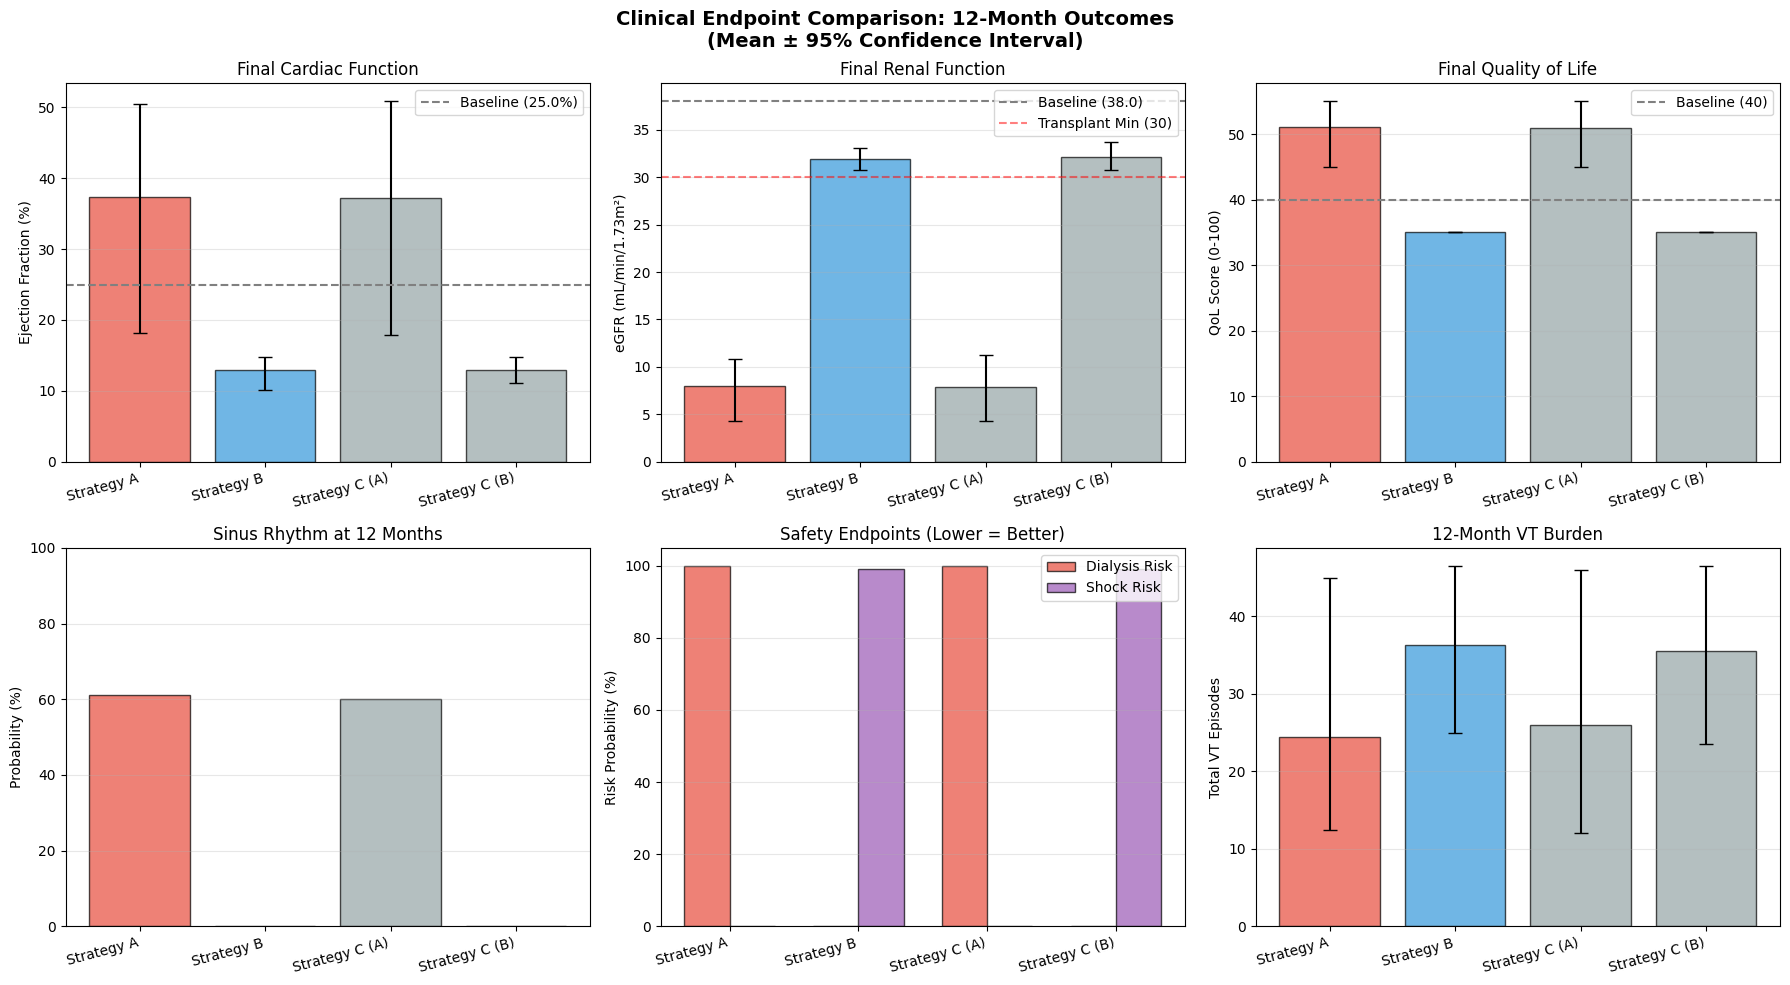


SIMULATION COMPLETE

Key Outputs Generated:
  1. Treatment trajectory plots (12-month projections)
  2. Clinical endpoint comparison dashboard
  3. Evidence-based treatment recommendation
  4. Uncertainty quantification (95% confidence intervals)

For clinical use, this model requires:
  - Prospective validation on patient cohorts
  - Integration with real-time monitoring data
  - FDA regulatory review and approval
  - Multidisciplinary clinical oversight



In [13]:
#==============================================================================
# SECTION 7: MAIN EXECUTION
#==============================================================================

def main():
    """
    Main execution function for Patient M.H. digital twin simulation

    Workflow:
    1. Initialize patient baseline
    2. Define treatment strategies
    3. Run Monte Carlo simulations
    4. Analyze clinical endpoints
    5. Generate visualizations
    6. Produce clinical report
    """

    print("="*80)
    print("PATIENT M.H. CARDIOVASCULAR-RENAL DIGITAL TWIN SIMULATOR")
    print("="*80)
    print("\nInitializing digital twin based on Sel et al. (2024) methodology...")
    print("Reference: J Am Heart Assoc. 2024;13:e031981\n")

    # Step 1: Initialize patient
    print("Step 1: Loading patient baseline parameters...")
    baseline = PatientBaseline()
    print(f"  ✓ EF: {baseline.ejection_fraction}%")
    print(f"  ✓ eGFR: {baseline.egfr} mL/min/1.73m²")
    print(f"  ✓ AF burden: {baseline.af_burden}%")
    print(f"  ✓ QoL: {baseline.quality_of_life}/100")

    # Step 2: Define strategies
    print("\nStep 2: Defining treatment strategies...")
    strategy_a = AggressiveRhythmControl(baseline)
    strategy_b = ConservativeRateControl(baseline)
    strategy_c1 = BridgeToTransplant(baseline, strategy_a)
    strategy_c2 = BridgeToTransplant(baseline, strategy_b)

    strategies = {
        'Strategy A: Aggressive Rhythm Control': strategy_a,
        'Strategy B: Conservative Rate Control': strategy_b,
        'Strategy C (A): Bridge-to-Transplant (Aggressive)': strategy_c1,
        'Strategy C (B): Bridge-to-Transplant (Conservative)': strategy_c2,
    }

    print(f"  ✓ {len(strategies)} strategies defined")

    # Step 3: Run simulations
    print("\nStep 3: Running Monte Carlo simulations...")
    print("  (100 simulations × 12 months × 4 strategies = 4,800 patient-months)")

    simulator = DigitalTwinSimulator(baseline, n_simulations=100)
    all_results = {}
    all_endpoints = {}

    for i, (strategy_name, strategy) in enumerate(strategies.items(), 1):
        print(f"  [{i}/{len(strategies)}] Simulating {strategy_name}...", end=" ")
        results = simulator.run_strategy_simulation(strategy)
        all_results[strategy_name] = results

        # Analyze endpoints
        endpoints = ClinicalEndpointAnalyzer.calculate_endpoints(results, baseline)
        all_endpoints[strategy_name] = endpoints
        print("✓")

    # Step 4: Generate visualizations
    print("\nStep 4: Generating visualizations...")
    visualizer = DigitalTwinVisualizer(baseline)

    print("  Creating trajectory plots...", end=" ")
    fig1 = visualizer.plot_trajectories(all_results, strategies)
    print("✓")

    print("  Creating endpoint comparison...", end=" ")
    fig2 = visualizer.plot_endpoint_comparison(all_endpoints, strategies)
    print("✓")

    # Step 5: Generate clinical report
    print("\nStep 5: Generating clinical decision support report...")
    report_gen = ClinicalReportGenerator()

    comparison_report = report_gen.generate_report(all_endpoints, baseline)
    recommendation = report_gen.generate_recommendation(all_endpoints)

    # Display results
    print("\n" + "="*80)
    print(comparison_report)
    print(recommendation)

    # Show visualizations
    print("\nDisplaying interactive visualizations...")
    plt.show()

    print("\n" + "="*80)
    print("SIMULATION COMPLETE")
    print("="*80)
    print("\nKey Outputs Generated:")
    print("  1. Treatment trajectory plots (12-month projections)")
    print("  2. Clinical endpoint comparison dashboard")
    print("  3. Evidence-based treatment recommendation")
    print("  4. Uncertainty quantification (95% confidence intervals)")
    print("\nFor clinical use, this model requires:")
    print("  - Prospective validation on patient cohorts")
    print("  - Integration with real-time monitoring data")
    print("  - FDA regulatory review and approval")
    print("  - Multidisciplinary clinical oversight")
    print("\n" + "="*80)

if __name__ == "__main__":
    main()